# Predicting galaxy properties

Given photometry of a galaxy, can we estimate its morphology? Or given its morphology, can we estimate its local density (environmental parameter)?

In [1]:
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd
from scipy.interpolate import griddata
import tensorflow as tf
import tflearn

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

%matplotlib inline

In [2]:
eco_columns = ['RAdeg', 'DEdeg', 'cz', 'rMag', 'logM', 'u-r', 'u-J', 'R50', 'R90', 'M', 'FM', 
               'Grp', 'Grpcz', 'FC', 'logMh', 'Den', 'FA', 'FHI', 'FG', 'CCr', 'CCb']

df = pd.read_csv(os.path.join(root_dir, 'data', 'eco_dr1.txt'),
                 delim_whitespace=True, skiprows=56, index_col=0,
                 names=eco_columns)

df.head()

,RAdeg,DEdeg,cz,rMag,logM,u-r,u-J,R50,R90,M,...,Grp,Grpcz,FC,logMh,Den,FA,FHI,FG,CCr,CCb
ECO12079,130.065,23.375,7230.9,-18.80,8.91,0.88,2.06,3.5,8.9,L,...,8480,7230.9,1,11.02,0.19,0,1,0,1.14,1.0
ECO02120,130.095,23.539,3534.8,-20.82,10.23,1.31,3.31,16.2,34.2,L,...,1918,3534.8,1,11.63,0.24,0,1,0,1.07,1.0
ECO08137,130.106,18.316,4373.9,-17.87,8.95,1.84,3.42,4.1,13.6,E,...,5958,4373.9,1,10.84,0.67,0,1,0,1.15,1.0
ECO00569,130.113,18.574,4491.7,-18.03,8.81,0.76,1.97,12.0,30.7,L,...,552,4491.7,1,10.87,0.74,0,1,0,1.15,1.0
ECO10139,130.126,27.631,6151.0,-18.99,9.23,1.18,2.30,13.4,27.7,L,...,7240,6151.0,1,11.06,0.57,1,2,0,1.10,1.0


### Relevant parameters
All of these galaxies are pretty nearby, so we don't need to care about things like their positions or redshift. Absolute $r$ magnitude, stellar mass, etc. are useful though.

Some morphologies aren't correct ("-"), and some $u-r$, $u-J$, $R90$ appear to be outliers or missing values.
Now we'll visualize the parameter range of everything (except morphology). 

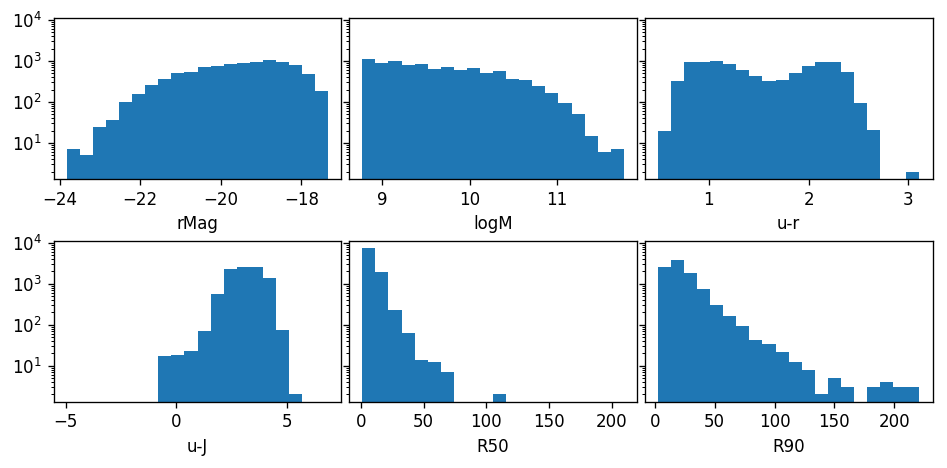

In [79]:
df = pd.read_csv(os.path.join(root_dir, 'data', 'eco_dr1.txt'),
                 delim_whitespace=True, skiprows=56, index_col=0,
                 names=eco_columns)


features = ['rMag', 'logM', 'u-r', 'u-J', 'R50', 'R90', 'M']
df = df[features]

# remove unclassified morphologies
df = df[df.M != '-']

# remove unphysical stuff
df = df[(df['u-r'] > -50) & (df['u-J'] > -10) & (df['u-J'] < 10) & (df['R90'] > 0)]

# make the sample mass-complete (logM > 8.75)
df = df[df['logM'] > 8.75]

# change morphology to the mapping 0: "E" and 1: "L"
df['M'] = map(lambda m: 0 if m == 'E' else 1, df['M'])

#X = df[features].as_matrix()
#y = df[target].as_matrix()[:, np.newaxis]

fig, axes = plt.subplots(2, 3, figsize=(8, 4), dpi=120, sharey=True, sharex=False)

for i, ax, feat in zip(range(6), axes.flat, features):
    ax.hist(df.iloc[:, i], bins=20)
    
    ax.set_xlabel(feat)
    ax.set_yscale('log')
    
fig.tight_layout(h_pad=0.1, w_pad=0.05)

### A simple neural network
Let's make a two-layer perceptron using `tflearn` (basically a simplified `tensorflow`). But since I have no idea what will work on my laptop, let's just take 500 random data points. Can we predict morphology from this?

In [80]:
X = df[['rMag', 'logM', 'u-r', 'u-J', 'R50', 'R90']].as_matrix()
y = df[['M']].as_matrix()

permutation = np.random.permutation(len(y))

X_train = X[permutation][:500]
y_train = y[permutation][:500]

In [81]:
ndata, ndim = X_train.shape
nclass = 2
Y_train = tflearn.data_utils.to_categorical(y_train.flat, nclass)

with tf.Graph().as_default():
    net = tflearn.input_data([None, ndim])
    net = tflearn.fully_connected(net, 32, activation='sigmoid', weights_init='normal',
                                  regularizer='L2', weight_decay=0.001)
    net = tflearn.fully_connected(net, nclass, activation='sigmoid')
    sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.5, decay_step=500)
    net = tflearn.regression(net, optimizer=sgd, loss='categorical_crossentropy')

    model = tflearn.DNN(net)
    model.fit(X_train, Y_train, show_metric=True, batch_size=100, n_epoch=500, snapshot_epoch=False)

Training Step: 2500  | total loss: 0.37183 | time: 0.016s
| SGD | epoch: 500 | loss: 0.37183 - acc: 0.8669 -- iter: 500/500


In [82]:
X_test = X[permutation][-500:]
y_test = y[permutation][-500:]
y_res = np.argmax(model.predict(X_test), axis=1)[:, np.newaxis]

print('The accuracy of our network is {:.4f}'.format(np.mean(y_res == y_test, dtype=float)))
print('The accuracy of random guessing is {:.4f}'.format(np.mean(np.random.randint(0, 2, 500) == y_test, dtype=float)))

The accuracy of our network is 0.9460
The accuracy of random guessing is 0.4854


Well, that was not terrible. Note that I got marginally better results by **lowering the batch size**. Let's try a slightly different network:

### A simple but deeper network

In [83]:
tf.reset_default_graph() # needed because the namespace gets corrupted each time
tflearn.init_graph(num_cores=4)

permutation = np.random.permutation(len(y))

X_train = X[permutation][:500]
y_train = y[permutation][:500]

net = tflearn.input_data(shape=[None, ndim])
net = tflearn.fully_connected(net, 128)
net = tflearn.fully_connected(net, 64)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, nclass, activation='relu')
net = tflearn.regression(net, optimizer='adam', loss='binary_crossentropy')

model = tflearn.DNN(net)
model.fit(X_train, Y_train, show_metric=True)

X_test = X[permutation][-500:]
y_test = y[permutation][-500:]
y_res = np.argmax(model.predict(X_test), axis=1)[:, np.newaxis]
print('The accuracy of our network is {:.4f}'.format(np.mean(y_res == y_test, dtype=float)))

Training Step: 79  | total loss: 0.63910 | time: 0.032s
| Adam | epoch: 010 | loss: 0.63910 - acc: 0.7302 -- iter: 448/500
Training Step: 80  | total loss: 0.64136 | time: 0.036s
| Adam | epoch: 010 | loss: 0.64136 - acc: 0.7258 -- iter: 500/500
--
The accuracy of our network is 0.6960


It actually seems like our original two layer network was better.

### Back to the simple multi-layer perceptron

In [84]:
permutation = np.random.permutation(len(y))

X_train = X[permutation][:500]
y_train = y[permutation][:500]

ndata, ndim = X_train.shape
nclass = 2
Y_train = tflearn.data_utils.to_categorical(y_train.flat, nclass)

with tf.Graph().as_default():
    net = tflearn.input_data([None, ndim])
    net = tflearn.fully_connected(net, 32, activation='sigmoid', weights_init='normal',
                                  regularizer='L2', weight_decay=0.001)
    net = tflearn.fully_connected(net, nclass, activation='sigmoid')
    sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.5, decay_step=500)
    net = tflearn.regression(net, optimizer=sgd, loss='categorical_crossentropy')

    model = tflearn.DNN(net)
    model.fit(X_train, Y_train, show_metric=True, batch_size=100, n_epoch=500, snapshot_epoch=False)

Training Step: 2500  | total loss: 0.33839 | time: 0.011s
| SGD | epoch: 500 | loss: 0.33839 - acc: 0.8839 -- iter: 500/500


In [85]:
X_test = X[permutation][-500:]
y_test = y[permutation][-500:]
y_res = np.argmax(model.predict(X_test), axis=1)[:, np.newaxis]

print('The accuracy of our network is {:.4f}'.format(np.mean(y_res == y_test, dtype=float)))

The accuracy of our network is 0.9340


### What about something simpler?

Why deep learning? Why not just use a simple decision tree or whatever classifer? They should be less expensive to execute. Let's see how some `scikit-learn` algorithms fare.

In [86]:
# Random forest
from sklearn.ensemble import RandomForestClassifier


permutation = np.random.permutation(len(y))
ndata, ndim = X_train.shape
nclass = 2

X_train = X[permutation][:500]
y_train = y[permutation][:500]
Y_train = tflearn.data_utils.to_categorical(y_train.flat, nclass)

clf = RandomForestClassifier(max_depth=4, random_state=256)
clf.fit(X_train, Y_train)

X_test = X[permutation][-500:]
y_test = y[permutation][-500:]
y_res = np.argmax(clf.predict(X_test), axis=1)[:, np.newaxis]

print('The accuracy of our Random Forest Classifer is {:.3f}'.format(np.mean(y_res == y_test, dtype=float)))

The accuracy of our Random Forest Classifer is 0.866


In [87]:
# Gaussian Process
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# let's just use first n=2 features for speed
n_dim = 2
X_train = X[permutation][:500, :n_dim]
y_train = y[permutation][:500, :n_dim]

# note that I'm using a k-d radial basis function
clf = GaussianProcessClassifier(kernel=RBF(np.ones(n_dim)), multi_class='one_vs_one')
clf.fit(X_train, y_train.flat)

X_test = X[permutation][-500:, :n_dim]
y_test = y[permutation][-500:, :n_dim]
y_res = np.argmax(clf.predict(X_test))

print('The accuracy of our Gaussian Process Classifer is {:.4f}'.format(np.mean(y_res == y_test, dtype=float)))

The accuracy of our Gaussian Process Classifer is 0.2860


Alright well that was both expensive and not accurate.

In [90]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

permutation = np.random.permutation(len(y))
ndata, ndim = X_train.shape
nclass = 2

X_train = X[permutation][:500]
y_train = y[permutation][:500]
Y_train = tflearn.data_utils.to_categorical(y_train.flat, nclass)

clf = RandomForestClassifier(max_depth=4, random_state=256)
clf.fit(X_train, Y_train)

X_test = X[permutation][-500:]
y_test = y[permutation][-500:]

for nn in 2 * np.arange(1, 5) + 1:    
    clf = KNeighborsClassifier(n_neighbors=nn)
    clf.fit(X_train, Y_train)
    
    y_res = np.argmax(clf.predict(X_test), axis=1)[:, np.newaxis]
    accuracy = np.mean(y_res == y_test, dtype=float)
    
    print('Using {:d} nearest neighbors, we find {:.3f} accuracy.'.format(nn, accuracy))    

Using 3 nearest neighbors, we find 0.844 accuracy.
Using 5 nearest neighbors, we find 0.860 accuracy.
Using 7 nearest neighbors, we find 0.854 accuracy.
Using 9 nearest neighbors, we find 0.844 accuracy.


### Regression problems

Up til now we've been trying to classify morphology (using a binary system). It might seem dumb to try to guess the optical morphology when you know features such as the stellar mass, $R_{90}$, etc., but still it's an interesting proof of concept. 

Let's now test `tflearn` and `sklearn` on regression problems -- trying to estimate the local density parameter. This is actually a nice use-case since ECO should be a volume-limited survey. However, it's also a rather small volume of the local universe, so we don't know how such regression algorithms/networks might fare in cluster environments.

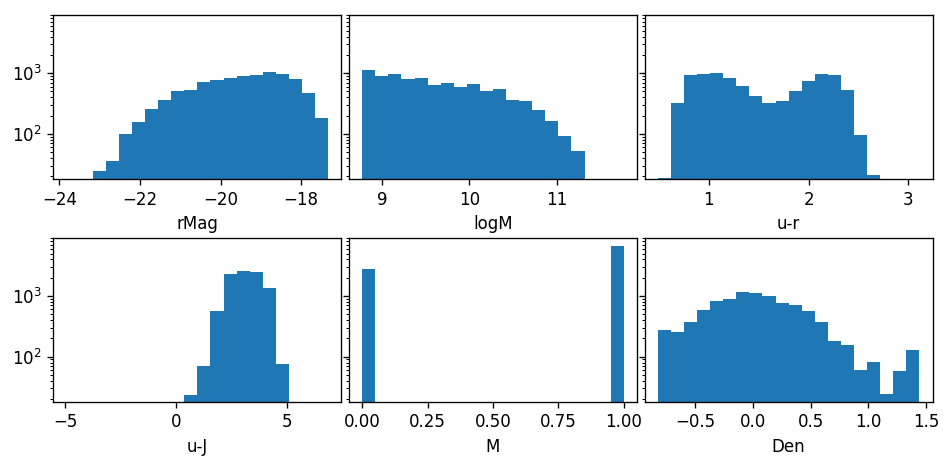

In [98]:
df = pd.read_csv(os.path.join(root_dir, 'data', 'eco_dr1.txt'),
                 delim_whitespace=True, skiprows=56, index_col=0,
                 names=eco_columns)

features = ['rMag', 'logM', 'u-r', 'u-J', 'M', 'Den']
df = df[features]

# remove unclassified morphologies
df = df[df.M != '-']

# remove unphysical stuff
df = df[(df['u-r'] > -50) & (df['u-J'] > -10) & (df['u-J'] < 10) & (df['Den'] > 0)]

# make the sample mass-complete (logM > 8.75)
df = df[df['logM'] > 8.75]

# change morphology to the mapping 0: "E" and 1: "L"
df['M'] = map(lambda m: 0 if m == 'E' else 1, df['M'])

# change density to log density
df['Den'] = df.Den.apply(lambda x: np.log10(x))

fig, axes = plt.subplots(2, 3, figsize=(8, 4), dpi=120, sharey=True, sharex=False)

for i, ax, feat in zip(range(6), axes.flat, features):
    ax.hist(df.iloc[:, i], bins=20)
    
    ax.set_xlabel(feat)
    ax.set_yscale('log')
    
fig.tight_layout(h_pad=0.1, w_pad=0.05)

In [99]:
# setting up matrix of values
X = df[['rMag', 'logM', 'u-r', 'u-J', 'M']].as_matrix()
y = df[['Den']].as_matrix()

permutation = np.random.permutation(len(y))

X_train = X[permutation][:500]
y_train = y[permutation][:500]

In [ ]:
permutation = np.random.permutation(len(y))

X_train = X[permutation][:-500]
y_train = y[permutation][:-500]

ndata, ndim = X_train.shape

with tf.Graph().as_default():
    net = tflearn.input_data([None, ndim])
    net = tflearn.fully_connected(net, 32, activation='sigmoid')
    net = tflearn.fully_connected(net, 32, activation = 'sigmoid')
    net = tflearn.fully_connected(net, 1, activation = 'linear')
    
    #sgd = tflearn.SGD(learning_rate=0.1, lr_decay = 0.01, decay_step=100)
    net = tflearn.regression(net, optimizer='adam', learning_rate=0.01, loss='mean_square', metric='R2')

    model = tflearn.DNN(net, tensorboard_dir='/tmp/tflearn_logs/regression')
    model.fit(X_train, y_train, show_metric=True, n_epoch=500, snapshot_epoch=False)

Training Step: 6305  | total loss: 0.16052 | time: 0.151s
| Adam | epoch: 045 | loss: 0.16052 - R2: 0.1543 -- iter: 3648/9068


In [137]:
X_test = X[permutation][-500:]
y_test = y[permutation][-500:]
y_res = model.predict(X_test)
print(np.column_stack((y_res[:10], y_test[:10])))

[[ 0.32270634  0.05307844]
 [ 0.15579817 -0.13667714]
 [-0.08812222  0.27184161]
 [-0.11220354 -0.07058107]
 [-0.08853242  0.07918125]
 [-0.08684397  0.29446623]
 [-0.07326284  0.55266822]
 [-0.08641997 -0.26760624]
 [-0.11667269 -0.10237291]
 [ 0.29787463  0.42488164]]
